In [13]:
#!/home/seiscomp/anaconda3/envs/quakenet/bin/python
import numpy as np
from scipy.spatial.distance import cdist
import pandas as pd
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc # python -m pip install cmcrameri
import colormaps as cmaps 
import cartopy.crs as ccrs # conda install -c scitools cartopy
import cartopy.feature as cfeature
import os
from tqdm import tqdm # pip install tqdm
import csv
#from tqdm import tqdm # pip install tqdm
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#from matplotlib.lines import Line2D
import warnings
from sklearn.neighbors import BallTree
#from sklearnex import patch_sklearn
#patch_sklearn()
from icecream import ic # pip install icecream
#from sklearn.neighbors import BallTree
#from sklearnex import patch_sklearn
#patch_sklearn()
warnings.filterwarnings("ignore")
# !python -m pip install ipympl
%matplotlib widget 

In [14]:
def firter_events_df(df, distance_threshold=0.5):
    coordinates = df[['Latitude (WGS84)', 'Longitude (WGS84)']].values
    radians_coords = np.radians(coordinates)
    tree = BallTree(radians_coords, metric='haversine')
    mask = np.ones(len(df), dtype=bool)
    distance_threshold_rad = distance_threshold / 6371.0
    for i in range(len(coordinates)):
        if not mask[i]:
            continue
        neighbors = tree.query_radius([radians_coords[i]], r=distance_threshold_rad)[0]
        mask[neighbors] = False
        mask[i] = True
    return df[mask]

# Function to calculate Haversine distances between points
def haversine_distances(events, stations):
    # Earth’s radius in kilometers, mean radius = 6,371 km
    EARTH_RADIUS = 6371
    
    # Convert degrees to radians for calculation
    event_coords_rad = np.radians(events)
    station_coords_rad = np.radians(stations)
    
    # Calculate differences
    dlat = event_coords_rad[:, np.newaxis, 0] - station_coords_rad[np.newaxis, :, 0]
    dlon = event_coords_rad[:, np.newaxis, 1] - station_coords_rad[np.newaxis, :, 1]
    
    # Calculate sin and cosines for latitude
    lat1_cos = np.cos(event_coords_rad[:, np.newaxis, 0])
    lat2_cos = np.cos(station_coords_rad[np.newaxis, :, 0])
    
    # Use the Haversine formula
    a = np.sin(dlat/2.0)**2 + lat1_cos * lat2_cos * np.sin(dlon/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    # Convert to distances
    distances = EARTH_RADIUS * c
    return distances

def add_polygon_from_bna(filename, ax, color):
    with open(filename, 'r') as file:
        header = file.readline().split(',')
        polygon_name = header[0].strip('"')
        num_points = int(header[2])
        
        points = []
        for _ in range(num_points):
            line = file.readline()
            points.append(list(map(float, line.split(','))))
        
        polygon = patches.Polygon(points, fill=None, label=polygon_name, color=color)
        ax.add_patch(polygon)
        plt.legend()

def plot_basemap(stations_plot_df, events_df, LATS, LONS):
    fig = plt.figure(figsize=(13*1.1, 10*1.1))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    # Split lons and lats
    lon1, lon2 = map(float, LONS.split(','))
    lat1, lat2 = map(float, LATS.split(','))
    ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())

    # Add roads and cities
    roads = cfeature.NaturalEarthFeature(category='cultural',
                                         name='roads',
                                         scale='10m',
                                         linewidth=0.4,
                                         facecolor='none')
    ax.add_feature(roads, edgecolor='gray')

    # Label a few cities manually
    cities_to_label = [
        {'name': 'Midland, TX', 'lon':  -102.077408, 'lat': 32.000507},
        {'name': 'Odessa, TX', 'lon': -102.367645, 'lat': 31.845682},
        {'name': 'Lubbock, TX', 'lon': -101.855166, 'lat': 33.577863},
        {'name': 'Big Spring, TX', 'lon': -101.479073, 'lat': 32.250286},
    ]
    for city in cities_to_label:
        ax.text(city['lon'], city['lat'], city['name'], transform=ccrs.PlateCarree(),
                fontsize=5, ha='right', color='gray')

    midland_bna = "midland.bna"
    #add_polygon_from_bna(delaware_bna, ax, 'black')
    add_polygon_from_bna(midland_bna, ax, 'black')
    #add_polygon_from_bna(north_bna, ax, 'purple')
    #add_polygon_from_bna(south_bna, ax, 'blue')

    # plot all stations
    #plt.scatter(stations_plot_df['Longitude (WGS84)'], stations_plot_df['Latitude (WGS84)'], marker='^',
    #            color='blue', label='Seismic Stations')
    # add station names
    """for index, row in stations_plot_df.iterrows():
        ax.text(row['Longitude (WGS84)'], row['Latitude (WGS84)'], row['Station Code'],
                transform=ccrs.PlateCarree(), fontsize=5, color='navy')"""

    # plot all the earthquakes as black dots 
    plt.scatter(events_df['Longitude (WGS84)'], events_df['Latitude (WGS84)'], color='black', s=1,
                alpha=0.9, label='Earthquakes')
    #plt.legend(loc='lower left', scatterpoints=1, markerscale=10)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, color='lightgrey')
    ax.add_feature(cfeature.OCEAN, color='lightblue')
    ax.add_feature(cfeature.LAKES, color='lightblue')
    ax.add_feature(cfeature.RIVERS, color='lightblue')
    ax.add_feature(cfeature.STATES, linestyle=':')

def save_map(png_dir, date_sufix, sufix=''):
    fig_sufix = f'dist_scatter_stations{sufix}_thr1{DIST_THRESHOLD}_thr2{DIST2_THRESHOLD}_{GRID_STEP}_{LONS}_{LATS}_{date_sufix}'
    # save png figure    
    if not os.path.exists(png_dir):
        os.makedirs(png_dir)
    fig_path = os.path.join(png_dir, fig_sufix + '.png')
    print(f'\nSaving map in {fig_path}\n')
    plt.savefig(fig_path, pad_inches=0.1, bbox_inches='tight', dpi=300)

In [15]:
events_csv = 'texnet_events_rpf_reduced.csv' # filtered by quality
stations_csv = 'texnet_stations.csv'

#events_csv = 'events_network_expansion_all.csv'
#events_csv = 'events_network_expansion_filtered.csv'
DIST_THRESHOLD = 4
DIST2_THRESHOLD = 10
MIN_STA_DIST2 = 1

# When query the grid, minimum number of the previously bad events that were improved, to consider the grid point as a potential station place in the graph of network expansion
MIN_N_EVENTS_IMPROVED = 2
GRID_STEP = 0.01
# Texas
#LONS = "-106,-93"
#LATS = "27.2,37.5"
# Midland Basin
LONS = "-103.2,-100"
LATS = "30.5,34"
OVERWRITE = False
W1 = 0.8
W2 = 0.2

### Get current stations array and events array

We have in Midland: 82 stations and 3294 events (PF) after close event filtering.

In [16]:
stations_df = pd.read_csv(stations_csv)
events_df = pd.read_csv(events_csv)

events_df['Origin Date'] = pd.to_datetime(events_df['Origin Date'])
date_sufix = events_df['Origin Date'].min().strftime('%Y%m%d') + '-' + events_df['Origin Date'].max().strftime('%Y%m%d')
date_sufix2 = events_df['Origin Date'].min().strftime('%Y-%m-%d') + ' to ' + events_df['Origin Date'].max().strftime('%Y-%m-%d')

stations_df = stations_df[~stations_df['Network Code'].isin(['N4', 'AM'])]

min_long, max_long = map(float, LONS.split(','))
min_lat, max_lat = map(float, LATS.split(','))

events_df = events_df[(events_df['Latitude (WGS84)'] >= min_lat) & (events_df['Latitude (WGS84)'] <= max_lat) &
                    (events_df['Longitude (WGS84)'] >= min_long) & (events_df['Longitude (WGS84)'] <= max_long)]

thr_filter = 111.32 * 0.01 * 0.5
print(f'Number of events before filtering: {events_df.shape[0]}')
events_df = firter_events_df(events_df, thr_filter)
print(f'Number of events after filtering: {events_df.shape[0]}')
    
stations_df = stations_df[(stations_df['Latitude (WGS84)'] >= min_lat) & (stations_df['Latitude (WGS84)'] <= max_lat) &
                            (stations_df['Longitude (WGS84)'] >= min_long) & (stations_df['Longitude (WGS84)'] <= max_long)]

ic(stations_df.shape, events_df.shape)
stations_coords = stations_df[['Latitude (WGS84)', 'Longitude (WGS84)']].values
events_coords = events_df[['Latitude (WGS84)', 'Longitude (WGS84)']].values
ic(stations_coords.shape, events_coords.shape)

ic| stations_df.shape: (82, 11), events_df.shape: (2639, 18)
ic| stations_coords.shape: (82, 2), events_coords.shape: (2639, 2)


Number of events before filtering: 2639
Number of events after filtering: 2639


((82, 2), (2639, 2))

### Get bad events (events that not meet the distance criteria)
* Distance criteria: 1 station within 2 km from the event and 2 stations within 10 km from the event.

The distances matrix original_ev_sta_distances has 3294 rows (events) and 82 columns (stations). Each row represents the distances from the event to the 82 stations.

* There are 2618 events that do not meet the DIST_THRESHOLD criteria (bad_ev_1).
* There are 761 events that do not meet the DIST2_THRESHOLD/MIN_STA_DIST2 criteria (bad_ev_2).

In [17]:
# Distances between all current stations and all events
original_ev_sta_distances = haversine_distances(events_coords, stations_coords)
ic(original_ev_sta_distances.shape)

# Good events 1
# boolean list with events have at least one station within DIST_THRESHOLD km
ev_within_dist_1 = np.any(original_ev_sta_distances <= DIST_THRESHOLD, axis=1)
ic(ev_within_dist_1.shape)

# Good events 2
ev_within_dist_2 = np.sum(original_ev_sta_distances <= DIST2_THRESHOLD, axis=1) >= MIN_STA_DIST2
ic(ev_within_dist_2.shape)

# Bad events criteria n1 (n_events,(lat, lon))
bad_ev_1 = events_coords[~ev_within_dist_1]
ic(bad_ev_1.shape)
# Bad events criteria n2 (n_events,(lat, lon))
bad_ev_2 = events_coords[~ev_within_dist_2]
ic(bad_ev_2.shape)

ic| original_ev_sta_distances.shape: (2639, 82)
ic| ev_within_dist_1.shape: (2639,)
ic| ev_within_dist_2.shape: (2639,)
ic| bad_ev_1.shape: (1689, 2)
ic| bad_ev_2.shape: (476, 2)


(476, 2)

### Get AOI grid and distances matrix (DM) between AOI grid points and events
DM.shape: (112350, 3294)
112350 grid points and 3294 events.

In [18]:
# Define the grid
latitudes = np.arange(min_lat, max_lat, GRID_STEP)
longitudes = np.arange(min_long, max_long, GRID_STEP)
grid = np.array(np.meshgrid(latitudes, longitudes)).T.reshape(-1,2)
ic(latitudes.shape, longitudes.shape, grid.shape)

# write to file
grids_dir = 'grids'
if not os.path.exists(grids_dir):
    os.makedirs(grids_dir)
DM_file_prefix = os.path.join(grids_dir, f'DM_{events_csv.split(".")[0]}_{LATS}_{LONS}_{GRID_STEP}_chunk')
#OVERWRITE = False
if not OVERWRITE and all(os.path.exists(f"{DM_file_prefix}_{i}.npy") for i in range(len(grid) // 1000 + 1)):
    print(f"Loading DM from {DM_file_prefix}_*.npy")
    # If chunks already exist and we do not want to overwrite, load and concatenate them
    try:
        # free memory
        del(DM)
    except NameError:
        pass
    DM = np.concatenate([np.load(f"{DM_file_prefix}_{i}.npy") for i in range(len(grid) // 1000 + 1)], axis=0)
else:
    print(f"Calculating DM for {len(grid)} grid points.")
    os.system(f"rm {DM_file_prefix}_*.npy")
    chunk_size = 1000  # Define a chunk size
    for i in tqdm(range(0, len(grid), chunk_size), desc="Chunks"):
        grid_chunk = grid[i:i+chunk_size]
        DM_chunk = haversine_distances(grid_chunk, events_coords)
        np.save(f"{DM_file_prefix}_{i // chunk_size}.npy", DM_chunk)
        #ic(f"Chunk {i // chunk_size} saved.")
    DM = np.concatenate([np.load(f"{DM_file_prefix}_{i}.npy") for i in tqdm(range(len(grid) // 1000 + 1), desc="Chunks")], axis=0)
ic(DM.shape)

ic| latitudes.shape: (350,)
    longitudes.shape: (321,)
    grid.shape: (112350, 2)
rm: cannot remove 'grids/DM_texnet_events_rpf_reduced_30.5,34_-103.2,-100_0.01_chunk_*.npy'

Calculating DM for 112350 grid points.


: No such file or directory
Chunks: 100%|██████████| 113/113 [00:46<00:00,  2.43it/s]
ic| DM.shape: (112350, 2639)


(112350, 2639)

## Get grid points that are 5 km away from the bad evens
DM_bad_ev_1.shape: (112350, 2618)

stations_fulfill_1_grid.shape: (3780, 2)

In [19]:
# Filter DM matrix to keep only the distances to the bad events
DM_bad_ev_1 = DM[:, ~ev_within_dist_1]
#ic(DM_bad_ev_1.shape)

In [20]:
# Get lats and lons of the grid points that are DIST_THRESHOLD km away from the bad events using the DM matrix
stations_fulfill_1_grid = grid[np.sum(DM_bad_ev_1 <= DIST_THRESHOLD, axis=1) >= MIN_N_EVENTS_IMPROVED]

#del(DM_bad_ev_1)
# lats: bad_ev_1_grid[:, 0], lons: bad_ev_1_grid[:, 1] of the grid points that are 5 km away from the bad events
ic(stations_fulfill_1_grid.shape)
# store stations_fulfill_1_grid in a csv file
stations_fulfill_1_grid_df = pd.DataFrame(stations_fulfill_1_grid, columns=['Latitude (WGS84)', 'Longitude (WGS84)'])
output_red_path = f'./red_fulfill_{MIN_N_EVENTS_IMPROVED}_{DIST_THRESHOLD}_{events_csv.split(".")[0]}_{date_sufix}.csv'
stations_fulfill_1_grid_df.to_csv(output_red_path, index=False)
print(output_red_path)

ic| stations_fulfill_1_grid.shape: (8939, 2)


./red_fulfill_2_4_texnet_events_rpf_reduced_20170113-20240520.csv


## Get grid points that are 10 km away from the bad events
stations_fulfill_2_grid.shape: (12531, 2)

In [21]:
# Filter DM matrix to keep only the distances to the bad events according to the second criteria
DM_bad_ev_2 = DM[:, ~ev_within_dist_2] 
ic(DM_bad_ev_2.shape)

ic| DM_bad_ev_2.shape: (112350, 476)


(112350, 476)

In [22]:
# Get lats and lons of the grid points that are DIST2_THRESHOLD km away from the bad events using the DM matrix
stations_fulfill_2_grid = grid[np.sum(DM_bad_ev_2 <= DIST2_THRESHOLD, axis=1) >= MIN_N_EVENTS_IMPROVED]
del(DM_bad_ev_2)
ic(stations_fulfill_2_grid.shape)
# store stations_fulfill_2_grid in a csv file
stations_fulfill_2_grid_df = pd.DataFrame(stations_fulfill_2_grid, columns=['Latitude (WGS84)', 'Longitude (WGS84)'])
output_yellow_path = f'./yellow_fulfill_{MIN_N_EVENTS_IMPROVED}_{DIST2_THRESHOLD}_{events_csv.split(".")[0]}_{date_sufix}.csv'
stations_fulfill_2_grid_df.to_csv(output_yellow_path, index=False)

ic| stations_fulfill_2_grid.shape: (18757, 2)


# Plot grid points, stations and earthquakes


Saving map in ./dist_scatter_stations_2_texnet_events_rpf_reduced_1_within_10_thr14_thr210_0.01_-103.2,-100_30.5,34_20170113-20240520.png



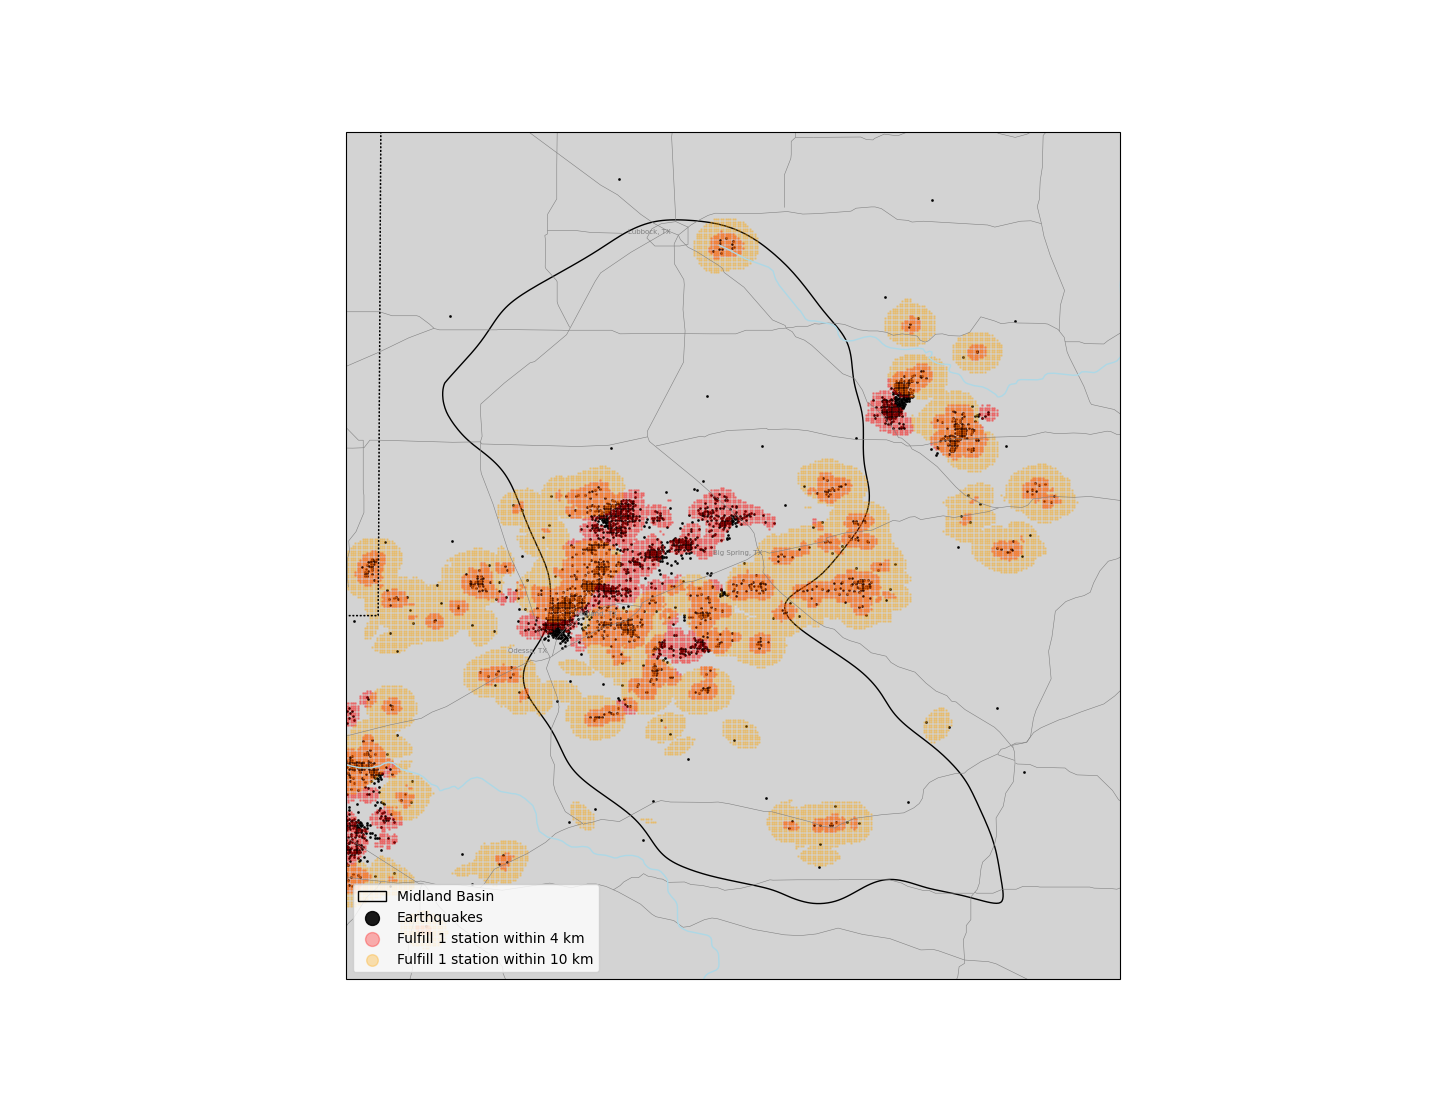

In [23]:
plot_basemap(stations_df, events_df, LATS, LONS)
fig_title = f'Potential Deployment Sites for Seismological Stations to Improve Event Coverage\n' \
            f'Aiming for 1 Station within {DIST_THRESHOLD} km and {MIN_STA_DIST2} Station within {DIST2_THRESHOLD} km.\n' \
            f'Grid step: {GRID_STEP}°. Events from {date_sufix2}.'
#plt.title(fig_title, fontsize=10)
plt.scatter(stations_fulfill_1_grid[:, 1], stations_fulfill_1_grid[:, 0], alpha=0.3,
            color='red', s=1, label=f'Fulfill 1 station within {DIST_THRESHOLD}')
plt.scatter(stations_fulfill_2_grid[:, 1], stations_fulfill_2_grid[:, 0], alpha=0.3,# marker='x',
            color='orange', s=0.7, label=f'Fulfill {MIN_STA_DIST2} station within {DIST2_THRESHOLD}'
            )
plt.legend(['Midland Basin', 'Earthquakes' ,f'Fulfill 1 station within {DIST_THRESHOLD} km', f'Fulfill {MIN_STA_DIST2} station within {DIST2_THRESHOLD} km'],
           loc='lower left', markerscale=10)

save_map(png_dir="./", date_sufix=date_sufix, sufix=f'_{MIN_N_EVENTS_IMPROVED}_{events_csv.split(".")[0]}_{MIN_STA_DIST2}_within_{DIST2_THRESHOLD}')

ic| count_bad_events.shape: (112350,)
    grid_with_counts.shape: (112350, 3)
ic| count_matrix.shape: (350, 321)


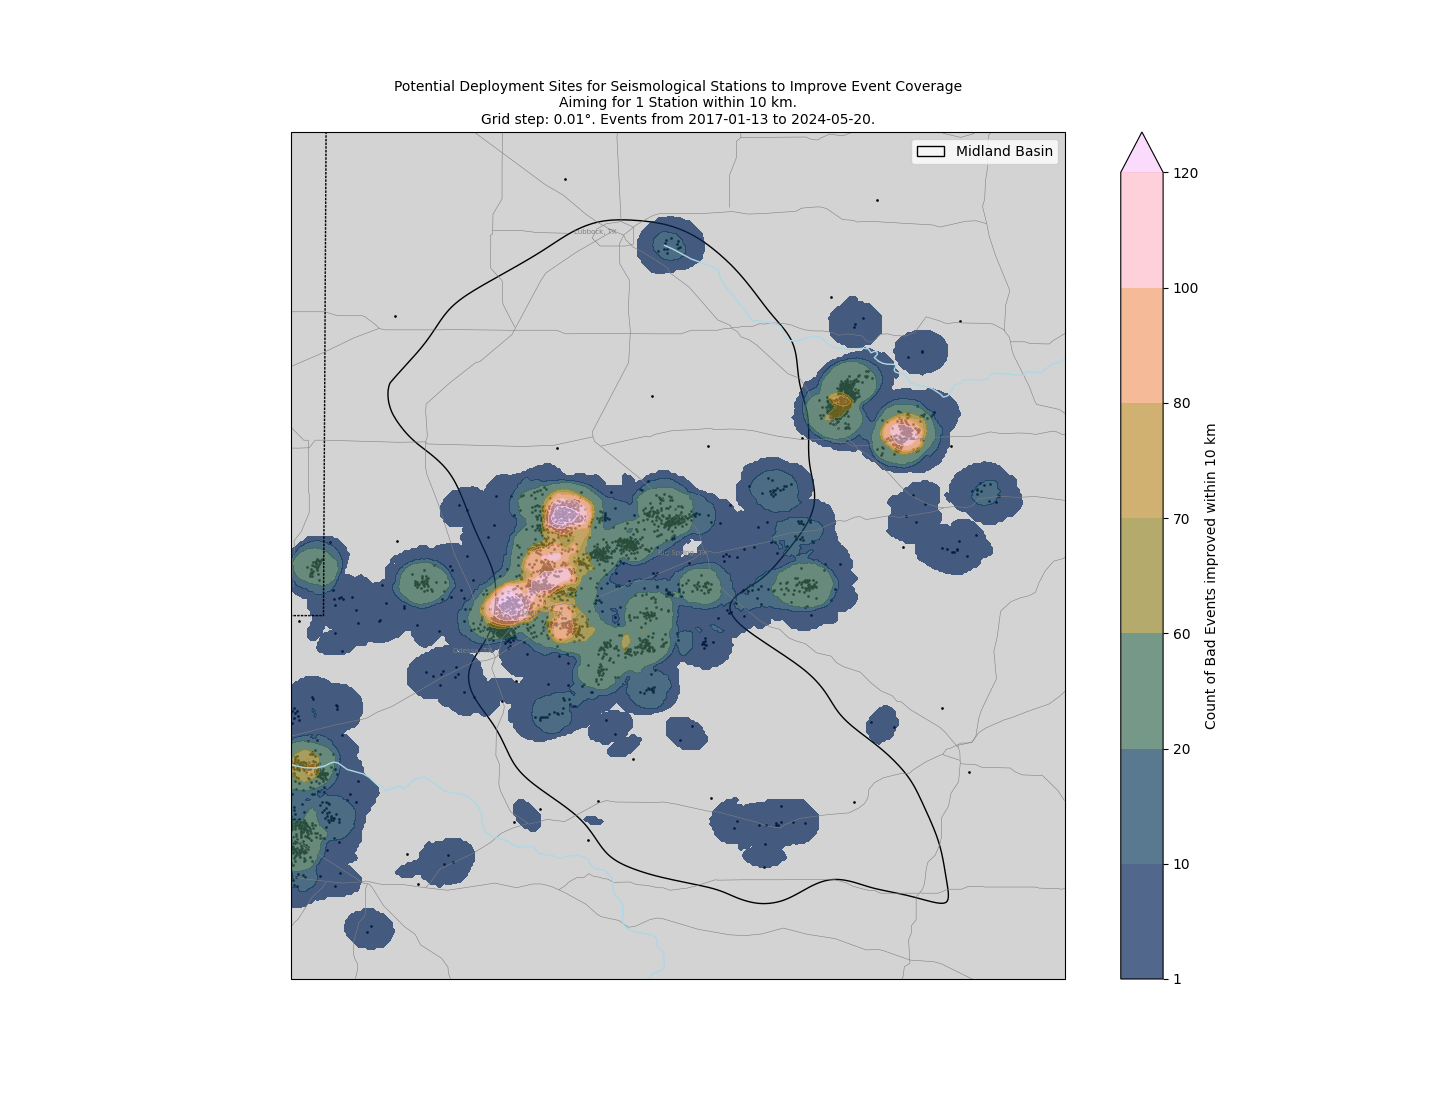


Saving map in ./dist_scatter_stations_contourf_1_thr14_thr210_0.01_-103.2,-100_30.5,34_20170113-20240520.png



In [24]:
# Function to count bad events within the distance threshold
def count_bad_events_within_threshold(DM_bad_ev, threshold):
    # Create a boolean matrix where True indicates the distance is within the threshold
    within_threshold = DM_bad_ev <= threshold
    
    # Sum along the columns to get the count of bad events for each grid point
    count_bad_events = np.sum(within_threshold, axis=1)
    
    return count_bad_events

DIST_THRESHOLD_H_MAP = 10

# Count the number of bad events within the threshold for each grid point
count_bad_events = count_bad_events_within_threshold(DM_bad_ev_1, DIST_THRESHOLD_H_MAP)
# Create a grid with the count of bad events for each grid point[:,
grid_with_counts = np.hstack((grid, count_bad_events[:, np.newaxis]))
ic(count_bad_events.shape, grid_with_counts.shape)
# Plotting the result using plt.contourf
count_matrix = count_bad_events.reshape(len(latitudes), len(longitudes))
ic(count_matrix.shape)

plot_basemap(stations_df, events_df, LATS, LONS)
#levels = [1, 10, 20, 40, 80]
levels = [1, 10, 20, 60, 70, 80, 100, 120]
#levels = 7
plt.contourf(longitudes, latitudes, count_matrix, alpha=0.7, transform=ccrs.PlateCarree(), cmap=cmc.batlow, levels=levels, extend='max')
plt.colorbar(label=f'Count of Bad Events improved within {DIST_THRESHOLD_H_MAP} km')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

fig_title = f'Potential Deployment Sites for Seismological Stations to Improve Event Coverage\n' \
            f'Aiming for 1 Station within {DIST_THRESHOLD_H_MAP} km.\n' \
            f'Grid step: {GRID_STEP}°. Events from {date_sufix2}.'
plt.title(fig_title, fontsize=10)
plt.show()
save_map(png_dir="./", date_sufix=date_sufix, sufix='_contourf_1')